# Evaluate synthetic data
Run this script in the thesis_venv environment.

In [12]:
import os
os.getcwd()

'C:\\Users\\jahutter\\Documents\\Programming\\Thesis code\\Evaluation'

#### Check we're running the script from thesis_venv (py 3.7):

In [13]:
import sys
print(sys.version)

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]


In [32]:
import numpy as np
print("Numpy version should be 1.19.5:", np.__version__)
import pandas as pd
print("Pandas version should be 0.24.0:", pd.__version__)
import glob
import sklearn
from data_evaluation import univariate_metrics, association_diff, privacy_metrics, dim_wise_pred
import json
import dython # version should be 0.7.1.post2 #0.6.4.post1
import seaborn as sns

pd.set_option('display.max_columns', None) # to see all cols when viewing db

Numpy version should be 1.19.5: 1.19.5
Pandas version should be 0.24.0: 1.3.5


***Choose which dataset and model to evaluate:***

In [33]:
dataset_name = "Census" # "Adult" #  "Asia" #  "Sachs" #      
model_name ="vaem" # "tvae" # "ctgan" # "ctab" #                    

if dataset_name in ["Adult", "Census", "Bank"]:
    real_file_root = "../Real_Datasets/"
else:
    real_file_root = "../BN_Datasets/"
real_path = real_file_root+ dataset_name+"/"+dataset_name
with open(real_path+"_meta.json") as json_file:
    meta = json.load(json_file)

target = meta["target"]
categorical_cols = meta["categorical_cols"]
categorical_cols.append(target)
binary_cols = meta["binary_cols"]
integer_cols = meta["numerical_cols"]

if model_name =="vaem":
    # to compare VAEMs synthetic dataset to real data, use processed dataset (has same normalization, scaling, etc)
    real_path = real_path+"_train_processed"  
    if dataset_name == "Census": 
        # for Census we deleted some categorical columns for training the VAEM
        real = pd.read_csv(real_path+".csv")
        cols = real.columns
        categorical_cols = list(set(cols) - set(integer_cols))

real_path = real_path + ".csv"

fake_file_root = "../Fake_Datasets/"
num_epoch = 300
exp_suffix=  "_"+str(num_epoch)+"epochs" #"_10epochs" # "_30epochs" #"_1epochs" #
# Take fake dbs generated on AWS:
fake_paths = glob.glob(fake_file_root+dataset_name+"/final-AWS/"+dataset_name+"_fake_"+model_name+exp_suffix+"*.csv")
#fake_paths = glob.glob(fake_file_root+dataset_name+"/"+dataset_name+"_fake_"+model_name+exp_suffix+"*.csv")
num_exp = len(fake_paths)
# Double check we have 3 fake datasets (from 3 runs):
fake_paths

['../Fake_Datasets/Census/final-AWS\\Census_fake_vaem_300epochs_1.csv',
 '../Fake_Datasets/Census/final-AWS\\Census_fake_vaem_300epochs_2.csv',
 '../Fake_Datasets/Census/final-AWS\\Census_fake_vaem_300epochs_3.csv']

## Evaluate univariate distribution

Check how well the properties of the individual features (columns) are reproduced:

In [34]:
# KS test for continuous (integer) cols, CS test for categorical cols
univ_stat_tests, df_summary = univariate_metrics(real_path, fake_paths, categorical_cols)
path = "../Evaluation/Univ_stat_tests/univ_stat_tests_"+dataset_name+"_"+model_name+exp_suffix+".csv"
univ_stat_tests.to_csv("../Evaluation/Univ_stat_tests/univ_stat_tests_"+dataset_name+"_"+model_name+exp_suffix+".csv", index=False)
df_summary.to_csv("../Evaluation/Univ_stat_tests/univ_stat_tests_"+dataset_name+"_"+model_name+exp_suffix+"_means.csv", index=False)
univ_stat_tests

Comparing real data to ../Fake_Datasets/Census/final-AWS\Census_fake_vaem_300epochs_1.csv
Comparing real data to ../Fake_Datasets/Census/final-AWS\Census_fake_vaem_300epochs_2.csv
Comparing real data to ../Fake_Datasets/Census/final-AWS\Census_fake_vaem_300epochs_3.csv


,Column,Statistic,Mean value
0,work_class,CS-test,0.629354
1,occupation,CS-test,1.000000
2,education,CS-test,0.999997
3,enroll_in_edu,CS-test,0.926714
4,marital_status,CS-test,0.997382
5,major_industry,CS-test,0.503190
6,major_occupation,CS-test,0.338405
7,race,CS-test,0.975324
8,hispanic_origin,CS-test,0.919399
9,gender,CS-test,0.948045


In [5]:
df_summary

,Statistic,Mean over all features,Standard deviation
0,CS-test,0.967064,0.045889
1,KS-test,0.787469,0.089128


## Evaluate multivariate distribution
How well are the feature interactions reproduced?

### Compute the difference between the association matrices and show in heatmap:

Values >0 indicate there are assocations between features in the real data which are not picked up by the generative model & reproduced in the fake data. Values <0 are perhaps even worse because it means the generative model added associations between features which were not present in the real data.

Computing association matrix of ../Real_Datasets/Adult/Adult_train_processed.csv
Computing association matrix of ../Fake_Datasets/Adult/final-AWS\Adult_fake_vaem_300epochs_1.csv
Computing association matrix of ../Fake_Datasets/Adult/final-AWS\Adult_fake_vaem_300epochs_2.csv
Computing association matrix of ../Fake_Datasets/Adult/final-AWS\Adult_fake_vaem_300epochs_3.csv


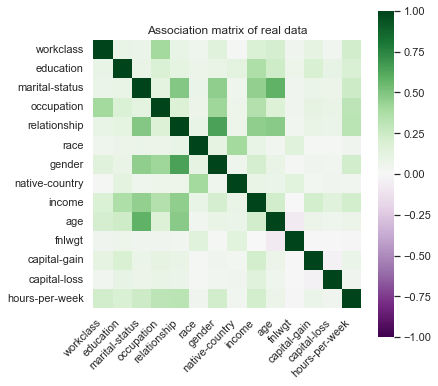

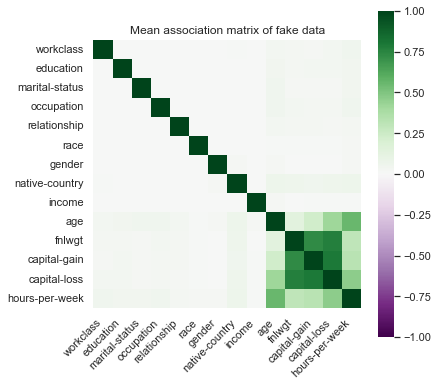

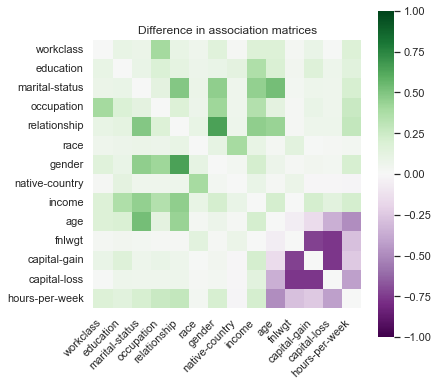

In [23]:
fig1, fig2, fig3, real_corr, mean_fake_corr, diff_corr = association_diff(real_path, fake_paths, categorical_cols)
real_corr.to_csv("../Evaluation/Association_matrix/assoc_mtx_"+dataset_name+"_"+model_name+exp_suffix+"_real.csv")
mean_fake_corr.to_csv("../Evaluation/Association_matrix/assoc_mtx_"+dataset_name+"_"+model_name+exp_suffix+"_fake.csv")
diff_corr.to_csv("../Evaluation/Association_matrix/assoc_mtx_"+dataset_name+"_"+model_name+exp_suffix+"_diff.csv")
fig1.figure.savefig("../Evaluation/Association_matrix/assoc_mtx_"+dataset_name+"_"+model_name+exp_suffix+"_real.png")
fig2.figure.savefig("../Evaluation/Association_matrix/assoc_mtx_"+dataset_name+"_"+model_name+exp_suffix+"_fake.png")
fig3.figure.savefig("../Evaluation/Association_matrix/assoc_mtx_"+dataset_name+"_"+model_name+exp_suffix+"_diff.png")


### Dimension-wise prediction

For each feature in the target_cols list, train a classifier (or regressor if feature is numerical) to predict that feature using the remaining features. If the target is numerical, measure the R2 score, if it is categorical, measure the F1 score of the predictor performance. Do this for all fake datasets and then compute mean over these fake datasets.

In [38]:
# optionally add variable target_cols to function call so as to use a select number of features as target
df = dim_wise_pred(real_path, fake_paths, categorical_cols, binary_cols, target, model_name)# target_cols=[]
df.to_csv("../Evaluation/Dim_wise_pred/dwp_"+dataset_name+"_"+model_name+exp_suffix+".csv", index=False)
df

Datasets come from VAEM model so need to process before building classifiers
Calling transform_df for train dataset
Calling transform_df for test dataset
Calling transform_df for fake dataset
Calling transform_df for fake dataset
Calling transform_df for fake dataset
TARGET FEATURE: workclass
Training a classifier on Real data
y_train set {0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0} does not match y_test set {0.0, 1.0, 2.0, 4.0, 6.0, 7.0, 8.0, 9.0} , prediction is  {0.0, 4.0}
y_train set {0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0} does not match y_test set {0.0, 1.0, 2.0, 4.0, 6.0, 7.0, 8.0, 9.0} , prediction is  {4.0}
y_train set {0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0} does not match y_test set {0.0, 1.0, 2.0, 4.0, 6.0, 7.0, 8.0, 9.0} , prediction is  {4.0}
TARGET FEATURE: education
Training a classifier on Real data
TARGET FEATURE: marital-status
Training a classifier on Real data
TARGET FEATURE: occupation
Training a classifier on Real data
TARGET FEATURE: relationship
Trai

,Target feature,Real_score,Fake1_score,Fake2_score,Fake3_score,Comp. time,Mean_fake_score
0,workclass,0.650749,0.571349,0.571349,0.571349,12.815868,0.571349
1,education,0.297898,0.169788,0.153745,0.207363,13.072947,0.176965
2,marital-status,0.773461,0.328442,0.306945,0.489741,11.921671,0.375043
3,occupation,0.249383,0.049427,0.095975,0.055552,13.108205,0.066985
4,relationship,0.698118,0.247695,0.237068,0.239468,11.672963,0.241410
5,race,0.782539,0.782291,0.782291,0.782291,10.389172,0.782291
6,gender,0.875105,0.799803,0.799828,0.799803,8.031836,0.799812
7,native-country,0.843599,0.843599,0.843497,0.843599,9.286137,0.843565
8,income,0.478551,0.000000,0.000000,0.000000,8.718940,0.000000
9,age,0.430503,-0.419408,-0.565919,-0.297393,21.677018,0.000000


In [9]:
df = pd.read_csv("../Evaluation/Dim_wise_pred/dwp_"+dataset_name+"_"+model_name+exp_suffix+".csv")
df.head()

,Target feature,Real_score,Fake1_score,Fake2_score,Fake3_score,Comp. time,Mean_fake_score
0,asia,0.000000,0.000000,0.000000,0.000000,5.972298,0.000000
1,tub,0.913242,0.000000,0.016949,0.000000,4.403128,0.005650
2,smoke,0.662352,0.652353,0.607337,0.588316,5.296645,0.616002
3,either,0.987768,0.893901,0.900813,0.889447,5.828321,0.894721
4,xray,0.722191,0.718976,0.721385,0.719777,4.681237,0.720046


Make scatterplot of dimension-wise prediction results:

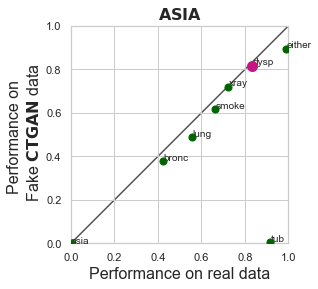

In [17]:
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(df["Real_score"], df["Mean_fake_score"], c="darkgreen", s=50, zorder=10)

# plot original target feature y in violet:
ax.scatter(df[df["Target feature"]==target]["Real_score"], df[df["Target feature"]==target]["Mean_fake_score"], c="mediumvioletred", s=100, zorder=10)

lims = [0,1]
# plot both limits against eachother to get y=x line
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Performance on real data", fontsize=16)
ax.set_ylabel("Performance on \n Fake $\\bf{}$ data".format(model_name.upper()), fontsize=16)
ax.set_title("$\\bf{}$".format(dataset_name.upper()), fontsize=16)
# add feature labels to datapoints:
for i, txt in enumerate(list(df["Target feature"])):
    ax.annotate(txt, (list(df["Real_score"])[i], list(df["Mean_fake_score"])[i]), xycoords='data', textcoords='offset points')
# see link about offsetting annotation:
# https://stackoverflow.com/questions/60786421/how-do-you-offset-text-in-a-scatter-plot-in-matplotlib
fig.savefig("../Evaluation/Dim_wise_pred/dwp_"+dataset_name+"_"+model_name+exp_suffix+".png", dpi=300)

## Privacy checks
Make sure the training dataset is not simply reproduced by the model

In [40]:
privacy_results, raw_df = privacy_metrics(real_path, fake_paths, dataset_name)
privacy_results.to_csv("../Evaluation/Privacy_checks/pr_ch_"+dataset_name+"_"+model_name+exp_suffix+".csv", index=False)
raw_df.to_csv("../Evaluation/Privacy_checks/pr_ch_"+dataset_name+"_"+model_name+exp_suffix+"_raw.csv", index=False)
privacy_results
print("Finished evaluating ",dataset_name, "results for ", num_exp, "experiment(s) and", num_epoch, " epochs of the", model_name.upper(), "model")

PROCESSING ../Fake_Datasets/Adult/final-AWS\Adult_fake_vaem_3000epochs_1.csv
PROCESSING ../Fake_Datasets/Adult/final-AWS\Adult_fake_vaem_3000epochs_2.csv
PROCESSING ../Fake_Datasets/Adult/final-AWS\Adult_fake_vaem_3000epochs_3.csv
Finished evaluating  Adult results for  3 experiment(s) and 3000  epochs of the VAEM model


In [41]:
raw_df.head()

,Dataset,Type,DCR,NNDR
0,Adult,F&R,1.037518,0.964075
1,Adult,F&R,1.156661,0.829714
2,Adult,F&R,1.076577,0.924360
3,Adult,F&R,1.995540,0.941594
4,Adult,F&R,0.865860,0.601311
